# Custom Transformer

In [23]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import set_config; set_config(display='diagram')

👇 Consider the following dataset

In [24]:
import pandas as pd

data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/08-Workflow/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

<Axes: xlabel='days_until_delivery', ylabel='Count'>

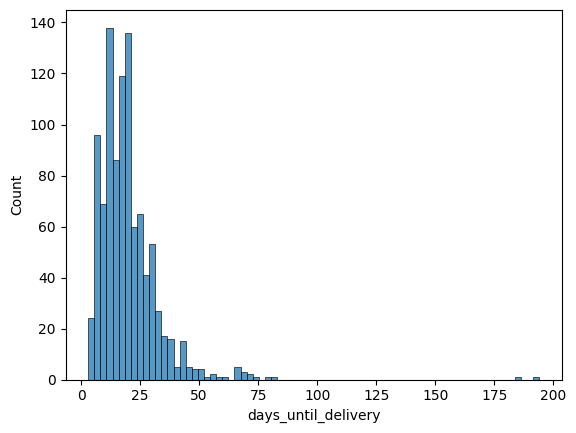

In [25]:
# Check target
sns.histplot(data.days_until_delivery)

## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

**Note:** for this challenge, ignore the holdout method, so no need to `train_test_split`!

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look weird, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse_output=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [34]:
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.preprocessing import RobustScaler,OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
volume_constructor = FunctionTransformer(lambda df: pd.DataFrame(df['product_length_cm']*df['product_height_cm']*df['product_width_cm']))
num_transformer = Pipeline([
    ('scaler', RobustScaler())
    ])
# Encode categorical values
cat_transformer = OneHotEncoder(drop='if_binary',
                                handle_unknown='ignore')
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']),
    ('cat_transformer', cat_transformer, ['customer_state', 'seller_state'])],
    remainder='passthrough')
union = FeatureUnion([
    ('preprocess', preprocessor), # columns 0-7
    ('volume', volume_constructor) # new column 8
])
pipe = Pipeline([
    ('preprocessor', union),
    ('model', Ridge())
])

pipe



Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('num_transformer',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['product_weight_g',
                                                                                   'product_length_cm',
                                                                                   'product_height_cm',
                                                                                   'product_width_cm']),
                                                                                 ('cat_transformer',
                                                                                  OneHotEncoder(drop='if_binary',
                                                                                                handle_unknown='ignore'),
                                                                                  ['customer_state',
                                                                                   'seller_state'])])),
                                                ('volume',
                                                 FunctionTransformer(func=<function <lambda> at 0x1519714e0>))])),
                ('model', Ridge())])

In [30]:
pipe_test[:-1].fit_transform(X).shape

(1000, 30)

#### 🧪 Test your pipe

In [35]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/08-Workflow/data-custom-transformer/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 0.56s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low $R_2$ scores are expected)
- Now, imagine you just received an new order `new_data`: predict its duration of delivery in a variable `prediction`

In [36]:
new_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/08-Workflow/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [42]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(pipe, X, y, cv=5, scoring='r2')
print(cv_results)



{'fit_time': array([0.01271391, 0.00719881, 0.00470924, 0.03028107, 0.00702381]), 'score_time': array([0.00500202, 0.00406003, 0.00338101, 0.00325489, 0.00303102]), 'test_score': array([-0.0357097 ,  0.06233524,  0.00773525, -0.0027177 ,  0.04534248])}


/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [43]:
pipe.fit(X, y)
prediction = pipe.predict(new_data)
prediction

array([16.83841458])

In [44]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/08-Workflow/data-custom-transformer/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 0.51s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Congratulation. Don't forget to add, commit and push your notebook.